In [ ]:
# install packages
!pip install stanza
!sudo apt-get update
!sudo mkdir -p /usr/share/man/man1
!sudo apt-get install -y openjdk-8-jdk
!pip install dill
!pip install flair
!pip install spacy
!pip install cython numpy
!pip install benepar[gpu]

     |████████████████████████████████| 2.0 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 72 kB 850 kB/s eta 0:00:011
     |████████████████████████████████| 1.4 MB 9.1 MB/s eta 0:00:01
     |████████████████████████████████| 516.2 MB 2.7 kB/s  eta 0:00:01
  Created wheel for benepar: filename=benepar-0.1.2-cp37-cp37m-linux_x86_64.whl size=115223 sha256=e0e72359048fa0e4e38393b19e9f26e53a86614b5da18c3b3bb147df49f5d4ff
  Stored in directory: /home/jovyan/.cache/pip/wheels/7d/12/66/371a9ac38cbe34739cc8a66517a1bec4bf29109fa599b6b63d
  Created wheel for nltk: filename=nltk-3.5-py3-none-any.whl size=1434674 sha256=8af459c4e3465096983e23c8ba4793ae5bee5ab3ad90ad0e4fea19b2195b9a6c
  Stored in directory: /home/jovyan/.cache/pip/wheels/45/6c/46/a1865e7ba706b3817f5d1b2ff7ce8996aabdd0d03d47ba0266
Successfully built benepar nltk


In [ ]:
# load libraries/packages
import subprocess
import os
import collections
import matplotlib.pyplot as plt
import scipy
import dill

from globalfn.alignments import all_alignments, aligned_with
from globalfn.annotations import all_annotations, annotation
from globalfn.full_text import full_text

import os
os.environ["CORENLP_HOME"] = "/home/jovyan/work/stanford-corenlp-4.0.0"
from stanza.server import CoreNLPClient

In [ ]:
class Node:
    """
    Represent each constituent as a node
    """
    def __init__(self, value):
        """
        value: constituent values such as NP, VP, etc., or word tokens if the node is a leaf node
        children: child nodes
        idx: the words that the constituent consists of
        parent: parent node
        """
        self.value = value 
        self.children = list()
        self.idx = list()
        self.parent = None
    
    def __repr__(self):
        """
        print the node as "(self.value (...))"
        """
        if not self.children:
            return "( " + self.value + " )"
        
        s = ""
        for child in self.children:
            s += child.__repr__()
        return "( " + self.value + " " + s + " )"

class Tracker:
    """
    Used for tracking the word position as we convert the parsed string into the constituency tree.
    """
    def __init__(self, index=0):
        self.index = index

def constituency_tree(tree, tracker):
    """
    @Function: create the constituency tree.
    :tree: spaCy tree
    :tracker: Tracker class for tracking the word positions
    :return: the root node of the constituency tree.
    """
    node = Node(tree.value)
    
    # leaf node
    if len(tree.child) == 0:
        node.idx = [tracker.index]
        tracker.index += 1
        return node
    
    # internal nodes
    for child in tree.child:
        node_child = constituency_tree(child, tracker)
        node_child.parent = node
        node.idx += node_child.idx
        node.children += [node_child]
    return node

T = Tracker()

In [ ]:
"""
Constituency parsing of DE sentences from TED Talk transcripts.
Create the dictionary ID_to_root_constituency_tree that maps a sentence ID to its constituency tree.
"""
ID_to_tokenized_text = {}
for ID, annos in all_annotations('de').items():
    for anno in annos:
        text = anno.tokenized_text
        ID_to_tokenized_text[ID] = text

ID_to_root_constituency_tree = {}

with CoreNLPClient(
        properties={
            'annotators': "tokenize,ssplit,pos,lemma,ner,parse,depparse",
            'tokenize.language': 'de',
            'pos.model': 'edu/stanford/nlp/models/pos-tagger/german-ud.tagger',
            'parse.model': 'edu/stanford/nlp/models/srparser/germanSR.ser.gz'
            },
        timeout=30000,
        memory='10G') as client:

    for ID, text in ID_to_tokenized_text.items():
        assert text.count(".") <= 1
        ann = client.annotate(text)
        T = Tracker()
        ID_to_root_constituency_tree[ID] = constituency_tree(ann.sentence[0].parseTree, T)

dill.dump(ID_to_root_constituency_tree, open("constituency_tree_stanford_dump.dill", 'wb'))

Starting server with command: java -Xmx10G -cp /home/jovyan/work/stanford-corenlp-4.0.0/* edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 30000 -threads 5 -maxCharLength 100000 -quiet True -serverProperties corenlp_server-588925e9d4bd4701.props -preload tokenize,ssplit,pos,lemma,ner,parse,depparse


In [ ]:
"""
1. Map each German sentence ID to its constituents using the function `get_all_nodes` and the constituency trees obtained in the cell above.
2. Map each English sentence ID to its constituents.
"""

def get_all_nodes(node, L):
    """
    :node: root node of the constituency tree
    :L: an empty list
    :return: a list of constituents nodes for a sentence
    """
    if not node.children:
        L.append(node)
        return L
    
    for child in node.children:
        get_all_nodes(child, L)
    L.append(node)
    return L

# German constituents
D2 = dill.load(open("constituency_tree_stanford_dump.dill", 'rb'))
de_ID_to_all_constituents_positions = collections.defaultdict(set)
for ID in D2.keys():
    root = D2[ID]
    res = list()
    res = get_all_nodes(root, res)
    de_ID_to_all_constituents_positions[ID] = set([tuple(node.idx) for node in res])

# English constituents
D = dill.load(open("en_constituents.dill", 'rb'))
en_ID_to_all_constituents_positions = collections.defaultdict(set)
for ID in D.keys():
    for sent in D[ID].sents:
        for constituent in sent._.constituents:
            en_ID_to_all_constituents_positions[ID].add(tuple(i for i in range(constituent.start, constituent.end)))


In [ ]:
"""
Maps sentence IDs to their respective tokenized sentence.
"""
en_id_to_tokenized_text = {id: text for id, text in full_text('en', tokenized=True, unzip=False)}
pt_id_to_tokenized_text = {id: text for id, text in full_text('pt', tokenized=True, unzip=False)}
de_id_to_tokenized_text = {id: text for id, text in full_text('de', tokenized=True, unzip=False)}
id_to_tokenized_text = {**en_id_to_tokenized_text, **pt_id_to_tokenized_text, **de_id_to_tokenized_text}

def fast_align(src_lang, tgt_lang):
    """
    src_lang: source language
    tgt_lang: target language
    @return: 
        - aligned_result:  defaultdict(list, {0: ['Good morning .', 'Bom dia .', '0-0 1-1 2-2'], ...})
        - aligned_sent_to_id: (dict) sentence (in the sentence alignment form) mapped to their IDs

    """
    aligned_sent_to_id = dict()
    with open(f"/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}", 'w+') as wf:
        for src_id, tgt_id_list in all_alignments(f'{src_lang}-{tgt_lang}').items():
            if type(src_id) is int:
                src_sent = id_to_tokenized_text[src_id] + " "
            else:
                src_sent = ""
                for id in src_id:
                    src_sent += id_to_tokenized_text[id] + " "

            tgt_sent = ""
            
            for tgt_id in tgt_id_list:
                tgt_sent += id_to_tokenized_text[tgt_id] + " "
            
            aligned_sent_to_id[src_sent.strip()] = src_id
            aligned_sent_to_id[tgt_sent.strip()] = tgt_id_list

            combined_sent_for_fast_align = src_sent + "||| " + tgt_sent + "\n"
            wf.write(combined_sent_for_fast_align)

    result = subprocess.run([f"/home/jovyan/work/fast_align/build/fast_align -i /home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang} -d -o -v > /home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}.forward.align"], shell=True, capture_output=True)

    aligned_result = collections.defaultdict(list)
    with open(f'/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}', 'r') as rf:
        for i, line in enumerate(rf):
            src, tgt = line.strip().split(" ||| ")
            aligned_result[i].append(src)
            aligned_result[i].append(tgt)

    with open(f'/home/jovyan/work/fast_align/build/globalfn_text.{src_lang}-{tgt_lang}.forward.align', 'r') as rf:
        for i, line in enumerate(rf):
            line = line.strip()
            aligned_result[i].append(line)

    assert aligned_result
    return aligned_result, aligned_sent_to_id

def visualize_alignment(aligned_result, sent_idx):
    """
    aligned_result[sent_idx]: ['Good morning .', 'Bom dia .', '0-0 1-1 2-2']
    where `sent_idx` refers to the line number in the alignment files such as "/home/jovyan/work/fast_align/build/globalfn_text.en-pt.forward.align"
    """
    src_tokens = tuple(aligned_result[sent_idx][0].split(' '))
    tgt_tokens = tuple(aligned_result[sent_idx][1].split(' '))
    cell_text = [[' ']*len(tgt_tokens)]*len(src_tokens)

    # coloring
    colors = [['w' for _ in range(len(tgt_tokens))] for _ in range(len(src_tokens))]
    for word_alignment in aligned_result[sent_idx][2].split(' '):
        tmp_src, tmp_tgt = word_alignment.split('-')
        colors[int(tmp_src)][int(tmp_tgt)] = "orange"


    fig, ax = plt.subplots()
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=cell_text,
                         cellColours=colors,
                         colLabels=tgt_tokens,
                         rowLabels=src_tokens,
                         loc='center')
    plt.title("Column = Target sentence (sentence that is unannotated)")
    plt.show()


In [ ]:
"""
Generate constituent-to-constituent alignment between EN and DE using the function `find_best_constituent`.
The output is `c2c_alignment` which is a dictionary that maps (source_sentence_ID, target_sentence_ID) to a dictionary of constituents alignment.
"""

def find_best_constituent(src_constituent, tgt_all_constituents, word_alignment):
    """
    @Function: Perform constituents alignment.
    :src_constituent: constituent of the source sentence.
    :tgt_all_constituents: all constituents of the target sentence.
    :word_alignment: words alignment between the source sentence and the target sentence.
    """
    def compute_score(constituent1, constituent2, word_alignment):
        res = 0
        for c1 in constituent1:
            for c2 in constituent2:
                if (c1, c2) in word_alignment:
                    res += 1
        
        return res/len(constituent2)

    word_alignment = word_alignment.split(' ')
    word_alignment = set([(int(tmp.split('-')[0]), int(tmp.split('-')[1])) for tmp in word_alignment])
    res = None
    best_score = 0
    for tgt_constituent in tgt_all_constituents:
        score = compute_score(src_constituent, tgt_constituent, word_alignment)
        if score > best_score:
            best_score = score
            res = tgt_constituent
    return res 

c2c_alignment = collections.defaultdict(dict)  # (src_id, tgt_id) -> {src_constituents: tgt_constituents} 
src_lang = 'en'
tgt_lang = 'de'
aligned_result, aligned_sent_to_id = fast_align(src_lang, tgt_lang)
for k, (src_sent, tgt_sent, word_alignment) in aligned_result.items():
    src_sent_id = aligned_sent_to_id[src_sent]  # one or many source sentences
    tgt_sent_ids = aligned_sent_to_id[tgt_sent]  # one or many target sentences

    if type(src_sent_id) is int and src_sent_id in all_annotations(src_lang) and len(tgt_sent_ids) == 1 and tgt_sent_ids[0] in all_annotations(tgt_lang):
        src_constituents = en_ID_to_all_constituents_positions[src_sent_id]
        tgt_constituents = de_ID_to_all_constituents_positions[tgt_sent_ids[0]]
        for src_constituent in src_constituents:
            result = find_best_constituent(src_constituent, tgt_constituents, word_alignment)
            if result is not None:
                c2c_alignment[(src_sent_id, tgt_sent_ids[0])][src_constituent] = result

In [ ]:
"""
Generate constituent-to-FE mapping for English source sentences.
To preserve the structure of `c2c_alignment`, the output of this cell is `src_c2fe_alignment`, which is a dictionary that maps (source_sentence_ID, target_sentence_ID) 
to a mapping of constituents to frames and frame elements.
"""
src_c2fe_alignment = collections.defaultdict(dict)  # (src_id, tgt_id) -> constituent -> (frame: frame elements)
for src_id, tgt_id in c2c_alignment.keys():
    annos = annotation(src_id)
    for c in c2c_alignment[(src_id, tgt_id)].keys():
        for anno in annos:
            try:
                all_valids = set([anno.tokenized_fe_idx[i] for i in c])
                if len(all_valids) == 1 and '-' not in all_valids:
                    src_c2fe_alignment[(src_id, tgt_id)][c] = {anno.frameName: list(all_valids)[0]}
            except:
                ...

src_c2fe_alignment

defaultdict(dict,
            {(1010, 1277): {(0,): {'Desirability': 'Evaluee'}},
             (1011, 1278): {(8,): {'Entity': 'Entity'},
              (4,): {'Motion': 'Source'},
              (5,): {'Motion': 'Carrier'},
              (7,): {'Motion': 'Carrier'}},
             (1012, 1279): {(3,): {'Departing': 'Theme'}},
             (1013, 1280): {(9,): {'Being_relevant': 'Phenomenon'},
              (5, 6, 7, 8): {'Being_relevant': 'Phenomenon'},
              (14, 15, 16, 17, 18): {'Being_relevant': 'Endeavor'},
              (3,): {'Being_relevant': 'Phenomenon'},
              (13, 14, 15, 16, 17, 18): {'Being_relevant': 'Endeavor'},
              (5,): {'Being_relevant': 'Phenomenon'},
              (16,): {'Desiring': 'Event'},
              (7,): {'Being_relevant': 'Phenomenon'},
              (3, 4): {'Being_relevant': 'Phenomenon'},
              (12, 13, 14, 15, 16, 17, 18): {'Being_relevant': 'Endeavor'},
              (16, 17, 18): {'Desiring': 'Event'},
              (

In [ ]:
"""
Generate constituent-to-FE mapping for German target sentences.
To preserve the structure of `c2c_alignment`, the output of this cell is `src_c2fe_alignment`, which is a dictionary that maps (source_sentence_ID, target_sentence_ID) 
to a mapping of constituents to frames and frame elements.
"""
tgt_c2fe_alignment = collections.defaultdict(dict)  # (src_id, tgt_id) -> constituent -> (frame: frame elements)
for src_id, tgt_id in src_c2fe_alignment.keys():
    src_constituents = src_c2fe_alignment[(src_id, tgt_id)]

    for src_constituent in src_constituents.keys():
        tgt_constituent = c2c_alignment[(src_id, tgt_id)][src_constituent]
        tgt_c2fe_alignment[(src_id, tgt_id)][tgt_constituent] = src_constituents[src_constituent]

# tgt_c2fe_alignment

In [ ]:
"""
Generate the constituent-to-constituent based annotation projection.
- `one_to_one_transferred_fe_lists` is annotation projection result: a dictionary that maps (source_sentence_ID, target_sentence_ID) to a frame and then 
to a sequence of frame elements labels from annotation projection.
- `one_to_one_transferred_fe_lists` is the gold standard: a dictionary that maps (source_sentence_ID, target_sentence_ID) to a frame and then 
to a sequence of gold frame elements labels.
"""
one_to_one_gold_fe_lists = collections.defaultdict(dict)  # tgt_sent_id -> frame name -> tokenized_fe_idx
one_to_one_transferred_fe_lists = collections.defaultdict(dict)  # (src_sent_id, tgt_sent_id) -> frame name -> tokenized_fe_idx
for src_id, tgt_id in tgt_c2fe_alignment.keys():
    for anno in annotation(tgt_id):
        frame = anno.frameName
        for tgt_constituent in tgt_c2fe_alignment[(src_id, tgt_id)].keys():
            if frame in tgt_c2fe_alignment[(src_id, tgt_id)][tgt_constituent]:
                transferred_fe = ['-' for _ in range(len(anno.tokenized_fe_idx))]
                FE = tgt_c2fe_alignment[(src_id, tgt_id)][tgt_constituent][frame]
                for idx in tgt_constituent:
                    transferred_fe[idx] = FE
                
                one_to_one_transferred_fe_lists[(src_id, tgt_id)][frame] = transferred_fe
                one_to_one_gold_fe_lists[tgt_id][frame] = anno.tokenized_fe_idx

Constituent-to-Constituent Annotation Transfer from EN to DE======
Total Hamming Loss: 0.248354
Hard Hamming Loss: 0.244591
Soft Hamming Loss: 0.003763
Exact Match Ratio: 0.035088
Percentage of Mismatched Number of Labels in a Sample: 0.807
Skewness: 1.651057141775064 (Right-skewed)


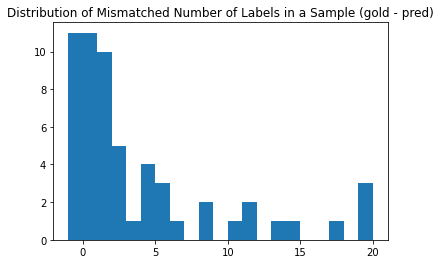

In [ ]:
def eval_res(gold, pred, print_result = True):
    """
    Calculate the following metrics:
    # Hamming Loss: fraction of FE labels that are incorrectly predicted (including wrong label)
    # Hard Hamming Loss: fraction of FE labels that are incorrectly predicted because of FP and FN
    # Soft Hamming Loss: fraction of FE labels that are incorrectly predicted because of wrong labels at the correct position
    # Exact Match Ratio: percentage of samples that have all their labels classified correctly
    # Distribution of Matching Number of FEs: distribution of the disparity of number of FEs identified (ideal: normal distribution centered at 0)
        # Right-skewed means that there are more FEs missing in the target sentence
        # Left-skewed means that there are many redundant FEs that shouldn't exist in the target sentence
    """
    hamming_wrong_labels = hamming_hard_wrong_labels = hamming_soft_wrong_labels = hamming_total_labels = 0
    dist_inexact = list()
    exact_match = exact_match_total = 0

    for (_, tgt_sent_id), transferred_res in pred.items():
        gold_sent_res = gold[tgt_sent_id]
        for frameName in transferred_res.keys():
            if frameName in gold_sent_res:
                gold_sent_fe_res = gold_sent_res[frameName]
                pred_sent_fe_res = transferred_res[frameName]
                assert len(gold_sent_fe_res) == len(pred_sent_fe_res)

                # compute hamming loss
                for i in range(len(gold_sent_fe_res)):
                    hamming_total_labels += 1
                    hamming_wrong_labels += int(gold_sent_fe_res[i] != pred_sent_fe_res[i])

                    if gold_sent_fe_res[i] != pred_sent_fe_res[i] and (gold_sent_fe_res[i] == '-' or pred_sent_fe_res[i] == '-'):
                        hamming_hard_wrong_labels += 1
                    
                    if gold_sent_fe_res[i] != pred_sent_fe_res[i] and gold_sent_fe_res[i] != '-' and pred_sent_fe_res[i] != '-':
                        hamming_soft_wrong_labels += 1

                # compute exact match ratio
                exact_match_total += 1
                exact_match += int(gold_sent_fe_res == pred_sent_fe_res)

                dist_inexact.append((len(gold_sent_fe_res) - gold_sent_fe_res.count('-')) - (len(pred_sent_fe_res) - pred_sent_fe_res.count('-')))
                

    hamming_loss = hamming_wrong_labels/hamming_total_labels
    hard_hamming_loss = hamming_hard_wrong_labels / hamming_total_labels
    soft_hamming_loss = hamming_soft_wrong_labels / hamming_total_labels
    exact_match_ratio = exact_match/exact_match_total
    print(f"Total Hamming Loss: {hamming_loss:3f}")
    print(f"Hard Hamming Loss: {hard_hamming_loss:3f}")
    print(f"Soft Hamming Loss: {soft_hamming_loss:3f}")
    print(f"Exact Match Ratio: {exact_match_ratio:3f}")
    print(f"Percentage of Mismatched Number of Labels in a Sample: {(len(dist_inexact) - dist_inexact.count(0))/len(dist_inexact):.3f}")
    print(f"Skewness: {scipy.stats.skew(dist_inexact)} ({'Right-skewed' if scipy.stats.skew(dist_inexact) > 0 else 'Left-skewed'})")
    plt.hist(dist_inexact, bins=[val for val in range(min(dist_inexact), max(dist_inexact) + 1)])
    plt.title("Distribution of Mismatched Number of Labels in a Sample (gold - pred)")

    return hamming_loss, hard_hamming_loss, soft_hamming_loss, exact_match_ratio, dist_inexact

print("Constituent-to-Constituent Annotation Transfer from EN to DE======")
res = eval_res(one_to_one_gold_fe_lists, one_to_one_transferred_fe_lists)